# XGBoost

In [ ]:
# import and run all cells of the preprocessing file

import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

In [32]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix
from xgboost import XGBClassifier

## 1. Hyperparams with GridSearch + (Cross validation)

In [31]:
xgb_model = XGBClassifier(random_state=0, eval_metric='logloss')

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_params = {
    'max_depth': [5, 6],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 300],
    'scale_pos_weight': [10, 100, 562],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=grid_params, scoring='roc_auc', cv=kfold, verbose=1, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/benpaffrath/.pyenv/versions/3.12.10/envs/ml-fraud-detection/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_p...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 6],
                         'n_estimators': [50, 100, 300],
                         'scale_pos_weight': [10, 100, 562]},
             scoring='roc_auc', verbose=1)

In [33]:
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 100}
Best ROC AUC: 0.9999932096372242


## 2. Train model with best params

In [8]:
best_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## 3. Evaluation

In [12]:
y_pred = best_model.predict(X_test)

# Returns class probabilities instead of class labels
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.75      0.88      0.81       101

    accuracy                           1.00     56962
   macro avg       0.88      0.94      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Test ROC AUC: 0.9651865997348754
[[56832    29]
 [   12    89]]


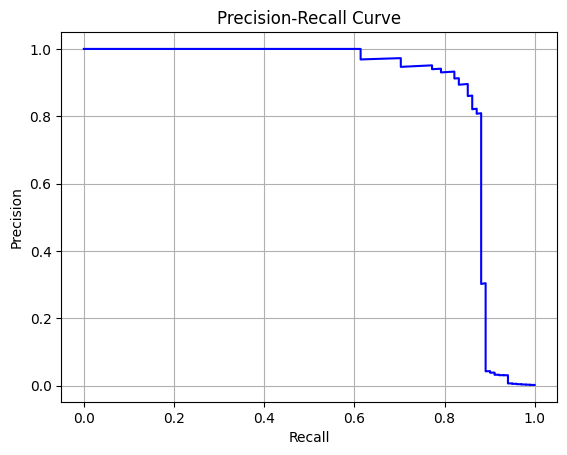

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [15]:
# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Cut of the last element, because precision_recall_curve returns one more precision/recall than thresholds
f1_scores = f1_scores[:-1]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1-Score: {best_f1:.4f}')
print(f'Precision at best threshold: {best_precision:.4f}')
print(f'Recall at best threshold: {best_recall:.4f}')


Best Threshold: 0.9998
Best F1-Score: 0.8737
Precision at best threshold: 0.9326
Recall at best threshold: 0.8218


In [17]:
# Converts the probabilities to binary (0, 1) predictions using the optimal threshold.
y_pred_optimal = (y_prob >= best_threshold).astype(int)

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred_optimal)

print(classification_report(y_test, y_pred_optimal))
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.93      0.82      0.87       101

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56855     6]
 [   18    83]]


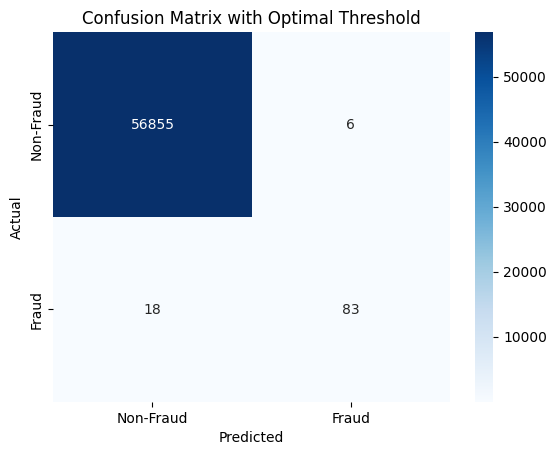

In [19]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimal Threshold')
plt.show()

The model achieves high precision (0.93) and solid recall (0.82), indicating it correctly identifies most fraud cases while minimizing false alarms. With only 6 false positives and 18 false negatives, this is a well-balanced result for fraud detection.